In [14]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms


In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device 

'cuda'

In [16]:
from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [17]:

# Download 10 percent and 20 percent datasets
data_10_percent_path = download_data(source="https://github.com/CarlosGaubertQ/dataset-eurosat-9-1/raw/main/EUROSAT.zip",
                                     destination="EUROSAT_10")

data_20_percent_path = download_data(source="https://github.com/CarlosGaubertQ/dataset-eurosat-8-2/raw/main/EUROSAT.zip",
                                     destination="EUROSAT_20")

[INFO] data\EUROSAT_10 directory exists, skipping download.
[INFO] data\EUROSAT_20 directory exists, skipping download.


In [18]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup the test directory
test_dir = data_10_percent_path / "test"

train_dir_10_percent, train_dir_20_percent, test_dir

(WindowsPath('data/EUROSAT_10/train'),
 WindowsPath('data/EUROSAT_20/train'),
 WindowsPath('data/EUROSAT_10/test'))

In [20]:
def create_effnetb2_model(num_classes:int=10, # default output classes = 3 (pizza, steak, sushi)
                          seed:int=42):
  # 1, 2, 3 Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, transforms

In [21]:

effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=10,
                                                      seed=42)

In [22]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output) 
summary(effnetb2, 
        input_size=(1, 3, 288, 288),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 288, 288]     [1, 10]              --                   Partial
├─Sequential (features)                                      [1, 3, 288, 288]     [1, 1408, 9, 9]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 288, 288]     [1, 32, 144, 144]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 288, 288]     [1, 32, 144, 144]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 144, 144]    [1, 32, 144, 144]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 144, 144]    [1, 32, 144, 144]    --                   --
│    └─Sequential (1)                                        [1, 32, 144, 144]    [1, 1

In [24]:

# Setup DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [25]:
from going_modular.going_modular import engine

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

# Training function (engine.py)
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn, 
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6194 | train_acc: 0.8252 | test_loss: 0.3314 | test_acc: 0.8950
Epoch: 2 | train_loss: 0.3776 | train_acc: 0.8766 | test_loss: 0.2756 | test_acc: 0.9104
Epoch: 3 | train_loss: 0.3430 | train_acc: 0.8850 | test_loss: 0.2605 | test_acc: 0.9192
Epoch: 4 | train_loss: 0.3266 | train_acc: 0.8920 | test_loss: 0.2525 | test_acc: 0.9181
Epoch: 5 | train_loss: 0.3145 | train_acc: 0.8953 | test_loss: 0.2398 | test_acc: 0.9214
Epoch: 6 | train_loss: 0.3087 | train_acc: 0.8946 | test_loss: 0.2421 | test_acc: 0.9211
Epoch: 7 | train_loss: 0.2995 | train_acc: 0.8971 | test_loss: 0.2296 | test_acc: 0.9218
Epoch: 8 | train_loss: 0.3003 | train_acc: 0.8966 | test_loss: 0.2246 | test_acc: 0.9233
Epoch: 9 | train_loss: 0.3092 | train_acc: 0.8939 | test_loss: 0.2279 | test_acc: 0.9251
Epoch: 10 | train_loss: 0.2856 | train_acc: 0.9030 | test_loss: 0.2183 | test_acc: 0.9214


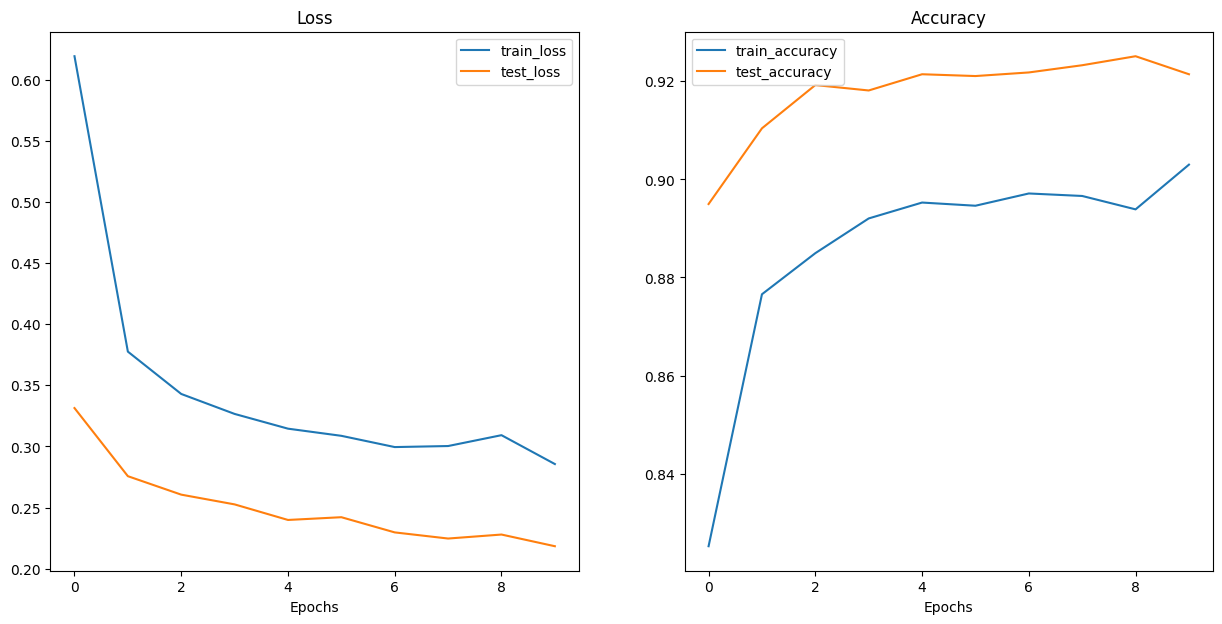

In [26]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [27]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="CNN_EffNetB2_Data_20_percent.pth")


[INFO] Saving model to: models\CNN_EffNetB2_Data_20_percent.pth
